In [110]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [111]:
import pandas as pd

In [112]:
import traces_generator as tg
import traces_extractor as te
import traces_process_miner as tpm
import traces_clustering as tc
import traces_anomaly_detector as tad

In [113]:
import logging

logging.getLogger().setLevel(logging.INFO)
log = logging.getLogger()
log.debug('Test debug')

In [114]:
train, test = tg.generate_samples(300, 100, 0, 0.25)
tg.data_to_csv(train, './data/train.csv')
tg.data_to_csv(test, './data/test.csv')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

In [115]:
train_raw_logs = pd.read_csv("./data/train.csv")
train_raw_traces = te.to_traces(train_raw_logs)

In [116]:
activities_processes = tpm.init_activities(train_raw_traces)

In [117]:
activities = {}

In [118]:
target_activity = 'PORTAL_findByNumbers'

for activity_process in activities_processes:
    activity_data = {'process': activity_process}
    activities.update({activity_process.name: activity_data})

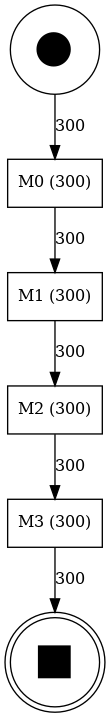

In [119]:
activities['M0']['process'].view_dfg()

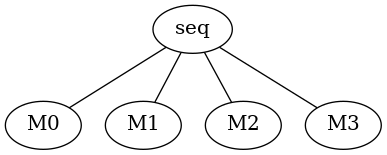

In [120]:
activities['M0']['process'].view_process_tree()

In [121]:
clustering_model = None

for activity in activities_processes:
    activity_traces = train_raw_logs[train_raw_logs['traceId'].isin(activity.train_traces)]
    activities[activity.name]['model'] = tc.ActivityEventClusteringModel(activity.name, traces=activity_traces)

[2023-06-16 16:47:58,324][INFO]: Doc2Vec lifecycle event {'params': 'Doc2Vec<dm/m,d10,n5,w5,s0.001,t3>', 'datetime': '2023-06-16T16:47:58.324837', 'gensim': '4.3.1', 'python': '3.10.6 (main, Mar 10 2023, 10:55:28) [GCC 11.3.0]', 'platform': 'Linux-5.19.0-43-generic-x86_64-with-glibc2.35', 'event': 'created'}
[2023-06-16 16:47:58,325][INFO]: collecting all words and their counts
[2023-06-16 16:47:58,326][INFO]: PROGRESS: at example #0, processed 0 words (0 words/s), 0 word types, 0 tags
[2023-06-16 16:47:58,344][INFO]: collected 29 word types and 3600 unique tags from a corpus of 3600 examples and 12300 words
[2023-06-16 16:47:58,345][INFO]: Creating a fresh vocabulary
[2023-06-16 16:47:58,346][INFO]: Doc2Vec lifecycle event {'msg': 'effective_min_count=1 retains 29 unique words (100.00% of original 29, drops 0)', 'datetime': '2023-06-16T16:47:58.345987', 'gensim': '4.3.1', 'python': '3.10.6 (main, Mar 10 2023, 10:55:28) [GCC 11.3.0]', 'platform': 'Linux-5.19.0-43-generic-x86_64-with-gl

activity = M0, best n_clusters = 12


In [122]:



def get_default_parser():
    parser = argparse.ArgumentParser()
    # Data and preprocess checkpoints directories
    parser.add_argument('--batch-size', type=int, default=256, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--epochs', type=int, default=50, metavar='N',
                        help='number of epochs to train (default: 50)')
    parser.add_argument('--window-size', type=int, default=4, metavar='N',
                        help='length of training window (default: 10)')
    parser.add_argument('--input-size', type=int, default=1, metavar='N',
                        help='preprocess input size (default: 1)')
    parser.add_argument('--hidden-size', type=int, default=64, metavar='N',
                        help='hidden layer size (default: 64)')
    parser.add_argument('--num-layers', type=int, default=2, metavar='N',
                        help='number of preprocess\'s layer (default: 2)')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--num-candidates', type=int, default=4, metavar='N',
                        help='the number of predictors sequences as correct predict.')
    # Pass container environment
    parser.add_argument('--hosts', type=list, default=['127.0.0.1'],
                        help='args for SageMaker distributed training.')
    parser.add_argument('--current-host', type=str, default='127.0.0.1',
                        help='args for SageMaker distributed training.')
    parser.add_argument('--preprocess-dir', type=str, default='./preprocess/',
                        help='the place where to store the preprocess parameter.')
    parser.add_argument('--data-dir', type=str, default='./data/',
                        help='the place where to store the training data.')
    parser.add_argument('--num-gpus', type=int, default=0,
                        help='number of gpu to train')
    parser.add_argument('--model-dir', type=str, default='./model/',
                        help='the place where to store the model parameter.')
    # Local mode
    parser.add_argument('--local', type=bool, default=True, help='local training preprocess.')
    return parser

In [123]:
import sys
import torch

sys.path.append('../')

torch.manual_seed(0)

for activity in activities_processes:
    parser = get_default_parser()
    parser.add_argument('--num-classes', type=int, default=activities[activity.name]['model'].num_classes, metavar='N',
                        help='the number of preprocess\'s output, must same as pattern size!')
    args, unknown = parser.parse_known_args()
    tad.train(args, activity.name)

Get train data loader


[2023-06-16 16:48:08,998][INFO]: Get train data loader


Number of session(./train/M0): 2400


[2023-06-16 16:48:09,002][INFO]: Number of session(./train/M0): 2400


Number of seqs(./train/M0): 2400


[2023-06-16 16:48:09,004][INFO]: Number of seqs(./train/M0): 2400


Saving the preprocess.


[2023-06-16 16:48:14,198][INFO]: Saving the preprocess.


In [124]:
test_raw_logs = pd.read_csv("./data/test.csv")
test_raw_traces = te.to_traces(test_raw_logs)
tpm.split_test_logs(test_raw_traces, activities_processes)

In [125]:
for activity in activities_processes:
    activity_traces = test_raw_logs[test_raw_logs['traceId'].isin(activity.test_traces)]
    activities[activity.name]['model'].predict(activity_traces)

In [126]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import json
import argparse

from traces_anomaly_detector import model_fn, input_fn, predict_fn

model_dir = './model'

for activity in activities_processes:
    parser = argparse.ArgumentParser()
    parser.add_argument('--threshold', type=int, default=2, metavar='N',
                        help='to determine the time series data is an anomaly or not.')
    args, unknown = parser.parse_known_args()

    model_info = model_fn(model_dir, activity.name)

    y_pred = []
    test_list = []
    with open('test/' + activity.name, 'r') as f:
        for line in f.readlines():
            line = list(map(lambda n: n - 1, map(int, line.strip().split())))
            request = json.dumps({'line': line})
            input_data = input_fn(request, 'application/json')
            response = predict_fn(input_data, model_info)
            test_list.append(response)
            y_pred.extend(response['predict_list'])

    y_true = []
    with open('test/' + activity.name + '_labels', 'r') as f:
        for line in f.readlines():
            y_true.extend(list(map(lambda n: n, map(int, line.strip().split()))))

    with open('./predict/' + activity.name, 'w') as f:
        for row in test_list:
            f.write(json.dumps(row))
            f.write('\n')

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print('accuracy: {}'.format(accuracy_score(y_true, y_pred)))
    print('precision: {}'.format(precision_score(y_true, y_pred)))
    print('recall: {}'.format(recall_score(y_true, y_pred)))
    print('f1_score: {}'.format(f1_score(y_true, y_pred)))

Loading the preprocess.


[2023-06-16 16:48:16,002][INFO]: Loading the preprocess.


accuracy: 0.9761702127659575
precision: 0.9583333333333334
recall: 0.46
f1_score: 0.6216216216216216


In [127]:
import shutil
import os

models_path = "./model"
shutil.rmtree(models_path)
os.mkdir(models_path)